In [171]:
import os
import imageio
import shutil
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

In [172]:
def create_or_clear_folder(folder_path):
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(folder_path)

### Heat PINN

In [132]:
def set_boundary_conditions(square_size, num_points_per_edge, T):
    x_boundary_right = np.ones(num_points_per_edge) * square_size

    x_boundary_left = np.zeros(num_points_per_edge)

    x_boundary = np.concatenate([x_boundary_right, x_boundary_left])

    u_boundary = np.zeros_like(x_boundary)

    t_boundary = np.linspace(0, T, len(x_boundary))

    class BoundaryConditions:
        def __init__(self, x, t, u):
            self.x = x
            self.t = t
            self.u = u

    boundary_conditions = BoundaryConditions(x_boundary, t_boundary, u_boundary)

    return boundary_conditions

In [133]:
def set_initial_conditions(initial_distribution_func, square_size, num_points, random=False):
    if random:
        x_initial = np.random.uniform(0, square_size, num_points)
    else:
        x_initial = np.linspace(0, square_size, num_points)
    
    t_initial = np.zeros_like(x_initial)
    
    u_initial = initial_distribution_func(x_initial)

    class Conditions:
        def __init__(self, x, t, u):
            self.x = x
            self.t = t
            self.u = u

    initial_conditions = Conditions(x_initial, t_initial, u_initial)
    
    return initial_conditions

In [134]:
def set_equation(square_size, num_points, T, random=False):
    if random:
        x_equation = np.random.uniform(0, square_size, num_points)
    else:
        x_equation = np.linspace(0, square_size, num_points)

    t_equation = np.linspace(0, T, len(x_equation))

    class Equation:
        def __init__(self, x, t):
            self.x = x
            self.t = t

    equation = Equation(x_equation, t_equation)

    return equation

In [141]:
def set_test(square_size, num_points, time, random=False):
    if random:
        x_test = np.random.uniform(0, square_size, num_points)
    else:
        x_test = np.linspace(0, square_size, num_points)

    t_test = np.ones(len(x_test)) * time

    class Test:
        def __init__(self, x, t):
            self.x = x
            self.t = t

    test = Test(x_test, t_test)

    return test

In [135]:
square_size = 1.0
T = 0.6

# Number of points in initial conditions
initial_points = 1000

# Generate initial conditions
initial_conditions = set_initial_conditions(lambda x: np.sin(np.pi * x), 
                                           square_size, 
                                           initial_points)

# Number of points in boundary conditions
boundary_points = 1000

# Generate boundary conditions
boundary_conditions = set_boundary_conditions(square_size, 
                                              boundary_points, 
                                              T)

# Number of points in equation
equation_points = 1000

# Generate equation
equation = set_equation(square_size, equation_points, T)

In [243]:
class PINN():
    def __init__(self, params, initial_conditions, boundary_conditions, equation):
        # Set data
        self.x_initial = torch.tensor(initial_conditions.x[:, np.newaxis],
                                      dtype=torch.float32, 
                                      requires_grad=True)
        self.t_initial = torch.tensor(initial_conditions.t[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True)
        self.u_initial = torch.tensor(initial_conditions.u[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True)
        
        self.x_boundary = torch.tensor(boundary_conditions.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True)
        self.t_boundary = torch.tensor(boundary_conditions.t[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True)
        self.u_boundary = torch.tensor(boundary_conditions.u[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True)
        
        self.x_equation = torch.tensor(equation.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True)
        self.t_equation = torch.tensor(equation.t[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True)

        # Coefficient of termal conductivity
        self.alpha = params.alpha

        # Size of computational field
        self.size = params.size

        # Number of points in initial conditions
        self.initial_points = params.initial_points

        # Number of points in boundary conditions
        self.boundary_points = params.boundary_points

        # Number of points in equation
        self.equation_points = params.equation_points

        # Time 
        self.time = params.time

        # Null vector is needed in equation loss
        self.null = torch.zeros((len(self.x_equation), 1))

        # Initialize network:
        self.network()

        # Optimizer
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), 
        #                                    lr=1, 
        #                                    max_iter=500, 
        #                                    max_eval=50000,
        #                                    history_size=50, 
        #                                    tolerance_grad=1e-07, 
        #                                    tolerance_change=0.5 * np.finfo(float).eps,
        #                                    line_search_fn="strong_wolfe")
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)

        # Number of epochs (for Adam optimizer)
        self.num_epochs = 15000

        # Loss function
        self.mse = nn.MSELoss()

        # Loss
        self.loss = 0

        # Iteration number
        self.iter = 0

        # Save plots
        self.output_folder = 'train_img'
        create_or_clear_folder(self.output_folder)


    def network(self):
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def function(self, x, t, is_equation=False):
        u_pred = self.net(torch.hstack((x, t)))

        if is_equation:
            dudx = torch.autograd.grad(u_pred, x, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udx2 = torch.autograd.grad(dudx, x, 
                                         grad_outputs=torch.ones_like(dudx), 
                                         create_graph=True)[0]
            dudt = torch.autograd.grad(u_pred, t, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            return u_pred, dudt, d2udx2

        return u_pred

    def closure(self):
        # Reset gradients
        self.optimizer.zero_grad()

        # Initial loss
        u_prediction = self.function(self.x_initial, self.t_initial)
        initial_loss = self.mse(u_prediction, self.u_initial)

        # Boundary loss
        u_prediction = self.function(self.x_boundary, self.t_boundary)
        boundary_loss = self.mse(u_prediction, self.u_boundary)

        # Equation loss
        _, dudt, d2udx2 = self.function(self.x_equation, self.t_equation, is_equation=True)
        heat_eq_prediction = dudt - self.alpha**2 * d2udx2
        equation_loss = self.mse(heat_eq_prediction, self.null)

        self.loss = initial_loss + 100*boundary_loss + equation_loss

        # Derivative with respect to weights
        self.loss.backward()

        self.optimizer.step() # For Adam

        self.iter += 1

        if self.iter % 10 == 0:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.loss))
            print('Initial loss: {:0.6f}'.format(initial_loss))
            print('Boundary loss: {:0.6f}'.format(boundary_loss))
            print('Equation loss: {:0.6f}'.format(equation_loss))

            test = set_test(self.size, self.equation_points, 0.4)
            x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
            t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

            u_test = self.function(x_test, t_test)

            # Plot numerical vs analytical solution
            self.plot_test(x_test, u_test, self.iter)

        return self.loss

    def train(self):
        # Training loop
        self.net.train()
        # self.optimizer.step(self.closure)

        # For Adam
        for _ in range(self.num_epochs):
            self.closure()

    def plot_test(self, x_test, u_test, iter):
        x_test = x_test.detach().numpy()
        u_test = u_test.detach().numpy()
        fig = plt.figure()
        plt.plot(x_test, u_test)
        plt.xlim(0, 1)
        plt.ylim(-0.1, 1.1)
        plt.grid()   
        plt.title(f'PINN Solution {iter}')
        plt.xlabel('x')
        plt.ylabel('u')
        self.output_folder
        plt.savefig(os.path.join(self.output_folder, f'{str(self.iter).zfill(4)}.png'))
        plt.close(fig)

In [244]:
class Params:
    def __init__(self, size, time, alpha, initial_points, boundary_points, equation_points):
        self.size = size
        self.time = time
        self.initial_points = initial_points
        self.boundary_points = boundary_points
        self.equation_points = equation_points
        self.alpha = alpha

In [ ]:
size = 1.0
time = 0.5
alpha = 0.5

# Generate initial conditions
initial_points = 100
initial_conditions = set_initial_conditions(lambda x: np.sin(np.pi * x), 
                                           size, 
                                           initial_points)

# Generate boundary conditions
boundary_points = 10
boundary_conditions = set_boundary_conditions(size, 
                                              boundary_points, 
                                              time)

# Generate equation
equation_points = 100
equation = set_equation(size, equation_points, time)

params = Params(size=size, 
                time=time, 
                alpha=alpha,
                initial_points=initial_points, 
                boundary_points=boundary_points,
                equation_points=equation_points)

# Create model
pinn = PINN(params, initial_conditions, boundary_conditions, equation)

# Train model
pinn.train()

# Save model
torch.save(pinn.net.state_dict(), 'model.pt')

In [246]:
output_folder = 'train_img'
os.listdir(output_folder)
images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]
imageio.mimsave(os.path.join(os.getcwd(), 'animation.gif'), images, fps=5, duration=0.1, loop=0)

C:\Users\dsash\AppData\Local\Temp\ipykernel_7436\3833992500.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]


In [50]:
pinn = PINN(initial_conditions, boundary_conditions, equation, alpha=0.5)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

test = set_test(size, 100, time)

x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u_pinn = pinn.function(x_test, t_test)

### Analytical solution for 2D

In [ ]:
def analytical_solution(x, y):
    l_x = 1.0
    l_y = 1.0
    u_1 = 1.0
    u_2 = 5.0
    lambda_n = [n * np.pi / l_x for n in range(1, 52)]
    return (u_1 + (u_2 - u_1) * (x / l_x)
    + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))

### Analytical solution for 1D and comparison with FDM

In [4]:
def initial_condition(x):
    return np.sin(np.pi * x)

In [3]:
def analytical_solution(x, t, alpha, L):
    sum_terms = 0
    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition(x) * np.sin(n * np.pi * x / L), 0, L)
        sum_terms += 2 / L * B_n * np.sin(n * np.pi * x / L) * np.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return sum_terms

In [230]:
def fdm_solver(L, T, num_points, alpha):
    dx = L / (num_points - 1)
    dt = 0.1 * dx**2 / alpha
    r = alpha * dt 

    x_values = np.linspace(0, L, num_points)
    u_values = np.zeros((num_points, int(T / dt) + 1))

    u_values[:, 0] = initial_condition(x_values)

    # Time-stepping with explicit finite difference scheme
    for n in range(1, int(T / dt) + 1):
        for i in range(1, num_points - 1):
            u_values[i, n] = (u_values[i, n - 1] + alpha**2 * dt *
                              (u_values[i + 1, n - 1] - 2 * u_values[i, n - 1] + u_values[i - 1, n - 1]) / dx**2)

    return x_values, u_values

In [273]:
def comparison_plot(x_values, u_fdm, u_analytical, u_pinn):
    plt.figure(figsize=(8, 6))
    plt.xlabel('x')
    plt.ylabel('temperature')

    plt.plot(x_values, u_fdm, label='FDM')
    plt.plot(x_values, u_analytical, label='Analytical')
    plt.plot(x_values, u_pinn, label='PINN')
    plt.legend()
    plt.show()

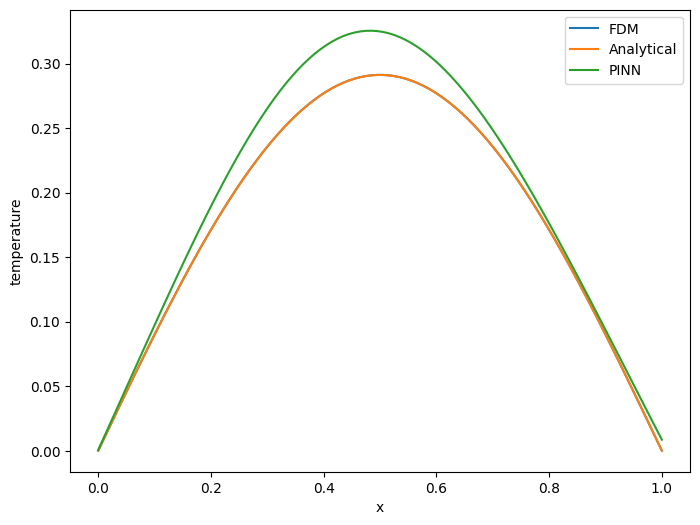

In [274]:
# Parameters
L = 1.0  # Length
T = 0.5  # Total simulation time
num_points = 100  # Number of spatial grid points
alpha = 0.5  # Thermal diffusivity

# Solve heat equation numerically
x_values, u_fdm = fdm_solver(L, T, num_points, alpha)
u_fdm = u_fdm[:, -1]

u_analytical = analytical_solution(x_values, T, alpha, L)

test = set_test(L, 100, T)
x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u_pinn = pinn.function(x_test, t_test).detach().numpy()

# Plot numerical vs analytical solution
comparison_plot(x_values, u_fdm, u_analytical, u_pinn)

In [275]:
def l2_norm(u1, u2):
    return np.sqrt(np.sum((u1 - u2)**2) / len(u1))

l2_norm_fdm = l2_norm(u_fdm, u_analytical)
l2_norm_pinn = l2_norm(u_pinn, u_analytical)

print(f"L2 norm (FDM vs Analytical): {l2_norm_fdm}")
print(f"L2 norm (PINN vs Analytical): {l2_norm_pinn}")

L2 norm (FDM vs Analytical): 2.0006872687507824e-05
L2 norm (PINN vs Analytical): 1.374534816694622
